In [2]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
from tqdm.notebook import tqdm_notebook

# Dataset Loading

Let's load all the paths of .wav files in a pandas DataFrame along their label to further load and processing steps

In [3]:
dir_data = "./Labelled/"
labels = "Bleatings ContactCalls Others".split()

In [13]:
data_to_load = []
for l in labels:
    for filename in os.listdir(f'{dir_data}{l}'):
        path = f'{dir_data}{l}/{filename}'
        data_to_load.append((path, l))
data_to_load = pd.DataFrame(data_to_load, columns=["path", "label"])
data_to_load

,path,label
0,./Labelled/Bleatings/evt_000_000_000681_210415...,Bleatings
1,./Labelled/Bleatings/evt_000_000_000682_210415...,Bleatings
2,./Labelled/Bleatings/evt_000_000_000683_210415...,Bleatings
3,./Labelled/Bleatings/evt_000_000_000684_210415...,Bleatings
4,./Labelled/Bleatings/evt_000_000_002434_210416...,Bleatings
...,...,...
822,./Labelled/Others/evt_003_003_069816_210609_06...,Others
823,./Labelled/Others/evt_003_003_069817_210609_06...,Others
824,./Labelled/Others/evt_003_003_069818_210609_06...,Others
825,./Labelled/Others/evt_003_003_069819_210609_06...,Others


# Analysis of data

Let's look at how many samples we have for each class

,label
Others,401
Bleatings,350
ContactCalls,76


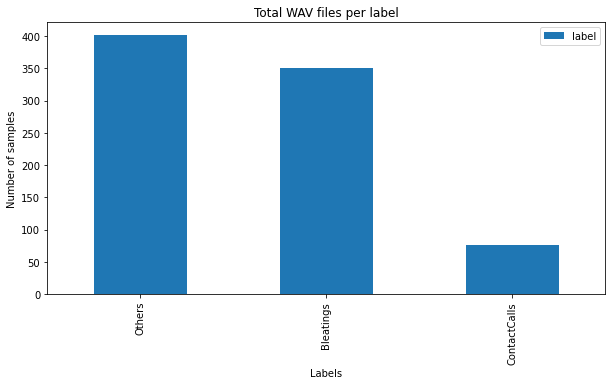

In [14]:
count_label = data_to_load_df['label'].value_counts().to_frame()
ax = count_label.plot(kind="bar", title='Total WAV files per label', figsize=(10,5))
ax.set_xlabel("Labels")
ax.set_ylabel("Number of samples")
count_label

As we can see the dataset is pretty imbalanced, in particular we have a fery few records for ContactCalls class. We must take care of this in the further steps.

Let's load the first sample and display the amplitude of the waveform

In [15]:
sample = librosa.load(data_to_load.iloc[0]["path"])
sample

(array([ 0.01291101,  0.00452354,  0.00358917, ..., -0.01543049,
        -0.01896373,  0.        ], dtype=float32),
 22050)

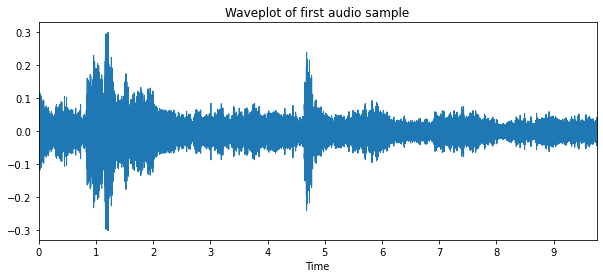

In [16]:
librosa_load, librosa_sampling_rate = sample
# plot the signal
plt.figure(figsize=(10, 4))
librosa.display.waveplot(librosa_load)
plt.title('Waveplot of first audio sample')
plt.show()

And with IPython Audio module we can also reproduce it.

In [17]:
ipd.Audio(librosa_load, rate=librosa_sampling_rate)

In [ ]:
y_harmonic, y_percussive = librosa.effects.hpss(librosa_load)
ipd.Audio(y_percussive, rate=librosa_sampling_rate)

# Extract features

In [23]:
# shuffle the data
data_to_load = data_to_load.sample(frac=1)

In [45]:
features = []
for element in tqdm_notebook(data_to_load.values.tolist()[:50]):
    features_vector = []
    filename = element[0]
    y, sr = librosa.load(filename)
    
    # add filename for later indexing the dataframe
    features_vector.append(filename)
    
    rms = librosa.feature.rms(y=y)
    features_vector.append(np.mean(rms))
    #chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    #spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    #spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    #rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    features_vector.append(np.mean(zcr))
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    features_vector = features_vector + [np.mean(e) for e in mfccs]
    
    #to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
    #for e in mfcc:
    #    to_append += f' {np.mean(e)}'
    
    # add the label
    features_vector.append(element[1])
    features.append(features_vector)
    

  0%|          | 0/50 [00:00<?, ?it/s]

In [59]:
features_df = pd.DataFrame(features, columns=["filename", "rms", "zcr"] + [f'mfcc{i}' for i in range(20)]+ ["label"])
features_df = features_df.set_index("filename")
features_df.head()

,rms,zcr,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,label
filename,,,,,,,,,,,,,,,,,,,,,
./Labelled/Bleatings/evt_001_003_034909_210502_134518.wav,0.006984,0.187475,-377.009338,95.880669,-42.657234,77.715477,-33.887909,33.206451,-2.512250,8.490808,...,-3.735909,8.510938,-6.560940,11.606267,-5.194788,7.343347,-0.619158,3.602003,0.078233,Bleatings
./Labelled/Bleatings/evt_000_001_002632_210416_073852.wav,0.062214,0.099904,-188.760193,145.959564,-68.584648,54.143364,-14.203813,1.955194,-5.561017,16.223532,...,2.527336,7.075812,-8.010324,9.080058,-7.769785,3.599059,5.259237,3.122564,0.849308,Bleatings
./Labelled/Others/evt_003_002_003569_210501_135115.wav,0.005709,0.127847,-474.727631,147.379089,-34.655479,61.227776,-11.979817,35.392506,0.455712,10.564780,...,7.283661,6.594476,0.378431,12.473774,-4.178606,12.500201,-5.843817,6.315655,6.741755,Others
./Labelled/Others/evt_000_001_020444_210423_220448.wav,0.020925,0.108683,-299.699280,171.500214,-83.280006,26.681047,-20.505777,20.649090,-2.309497,8.671416,...,-0.587268,7.369606,-3.986548,0.528012,-12.755464,4.904510,-4.969002,1.672815,3.406864,Others
./Labelled/Others/evt_001_002_018572_210425_094233.wav,0.004345,0.096446,-426.041168,123.996414,-34.002785,61.306442,-18.612503,27.970829,-2.241459,13.966869,...,-1.264318,10.060466,-7.955052,12.376381,-4.092283,5.181476,-1.892008,0.991476,-1.825804,Others


In [48]:
features_df.to_csv("sample.csv")